In [214]:
import os
import openai
import pandas as pd
import tiktoken
import numpy as np
from collections import Counter
from dotenv import load_dotenv
from openai import OpenAI
from langchain.schema import Document
from langchain_pinecone import PineconeVectorStore
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import Pinecone
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Necessary pip installation commands include:
- pip install openai
- pip install pandas
- pip install tiktoken
- pip install numpy
- pip install python-dotenv
- pip install langchain
- pip install langchain-pinecone
- pip install langchain-core
- pip install langchain-openai

#### <b>Note</b>: have a <b>.env</b> file already created for accessing API key

In [215]:
# retrieving dataset utilized for evaluation
df = pd.read_csv('../../data/csv/semi_toxic_classification_evaluation_set.csv')
df['Toxic'] = df['Toxic'].apply(lambda x: str(int(x)))
df

,Text,Toxic
0,Date When did this algorithm get invented ?,0
1,answered them many times ! but they didnt answ...,0
2,IAC There is a discussion on article 's talk p...,0
3,Spandam 's laugh ? I 'm listening to it and al...,0
4,AND HAVING A FUCKIN ' BITCH ASS DAY '' ',1
...,...,...
995,"Oh , well Harry finally got his payback on me ...",1
996,this page is about random crap talk .. just ed...,1
997,I 've reverted the editsBOTH OF THEM VIOLATED ...,0
998,"I used the exact same bullshit you wrote , hyp...",1


In [216]:
# retrieving API Key from OpenAI platform
load_dotenv()
# Initialize the tokenizer for GPT-3.5 Turbo and GPT-4
tokenizer = tiktoken.get_encoding("cl100k_base")
input_token_cost = ((0.50 / 1000000))
output_token_cost = ((1.50 / 1000000))
FINE_TUNED_TOXIC_DETECTION_API_KEY = os.getenv('FINE_TUNED_TOXIC_DETECTION_API_KEY')
REGULAR_TOXIC_DETECTION_API_KEY = os.getenv("REGULAR_TOXIC_DETECTION_API_KEY")
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pc_index = os.getenv('PINECONE_GPT_SEMI')

In [217]:
# instantiating client with API key
fine_tuned = OpenAI(
    api_key=FINE_TUNED_TOXIC_DETECTION_API_KEY
)

In [218]:
# initializing Pinecone vector database instance
docSearch = Pinecone(
    index_name=pc_index,
    embedding=OpenAIEmbeddings(openai_api_key=REGULAR_TOXIC_DETECTION_API_KEY)
)

In [219]:
# checks for high repetition of characters that OpenAI
# will throw an error against
def check_repetition(text):
  # splits text to check individuals words
  words = text.lower().split()
  word_counts = Counter(words)
  repeated_words = {word: count for word, count in word_counts.items() if count > 1}
  for value in repeated_words:
    if repeated_words[value] >= 25:
      return True
  return False

In [220]:
# appends one/few shot examples to evaluation prompt
def shot_additions(examples):
   evaluation_prompt = ''
   # Read the evaluation prompt from the text file with utf-8 encoding
   with open("../../data/text/rag_prompts/gpt-3-5-0125-two-shot-prompt.txt", "r", encoding="utf-8") as file:
        evaluation_prompt += file.read() 
   for example in examples:
       # separates example key and values
       split_ex = example.split(' - ')
       comment = split_ex[0]
       label = split_ex[1]
       evaluation_prompt += '\n\nText: \"' + comment + "\"" + '\n\n' + label

   evaluation_prompt += '\n\nClassify the following comment:'

   return evaluation_prompt

In [221]:
# queries vector database for custom,
# with similar examples to user prompt
def rag_prompt(text):
    two_shots = []
    # queries Pinecone database
    search_results = docSearch.max_marginal_relevance_search(text, k=25, fetch_k=50)
    for i in range(len(search_results)):
        content = search_results[i].page_content
        # prevents repetition which will cause errors within OpenAI
        if len(content) <= 250:
            two_shots.append(content)
        # two valid examples found
        if len(two_shots) == 3:
            break
    return shot_additions(two_shots)

In [222]:
# retrieving dataset utilized for evaluation
tuned = pd.DataFrame(columns=['Text', 'Toxic'])
tokens = pd.DataFrame(columns=['Prompt', 'Input', 'Output', 'Total'])

In [223]:
evaluation_prompt = ''
# Read the evaluation prompt from the text file with utf-8 encoding
with open("../../data/text/rag_prompts/gpt-3-5-0125-two-shot-prompt.txt", "r", encoding="utf-8") as file:
    evaluation_prompt += file.read()

In [224]:
evaluation_prompt

'Classify these comments as either toxic (1) non-toxic (0). Toxic comments contain offensive, harmful, or abusive language. Label 1 for toxic and 0 for non-toxic\n\nExamples for Reference:'

In [226]:
# processing fine-tuned GPT-3.5-turbo-0125 model across entire dataset 
# with advanced prompting with RAG support
for index, row in df.iterrows():
    text = row['Text']
    print(f"Starting Completion at Index: {index}")
    # ft:gpt-3.5-turbo-0125:personal::AujUh1US
    completion = fine_tuned.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:personal::AujUh1US",
        messages=[
            {
                "role": "system", 
                "content": rag_prompt(text)
            },
            {
                "role": "user",
                "content": text
            }
        ]
    )
    print(f'Finished Completion {index}!')
    tuned.loc[index] = [row['Text'], completion.choices[0].message.content]
        # tokenize the string
    tokens_object = {
        'prompt': len(tokenizer.encode(evaluation_prompt)),
        'input': len(tokenizer.encode(row['Text'])),
        'output': len(tokenizer.encode(completion.choices[0].message.content))
    }
    total_tokens = tokens_object['prompt'] + tokens_object['input'] + tokens_object['output']
    tokens.loc[index] = [tokens_object['prompt'], tokens_object['input'], tokens_object['output'], total_tokens]


Starting Completion at Index: 0
Finished Completion 0!
Starting Completion at Index: 1
Finished Completion 1!
Starting Completion at Index: 2
Finished Completion 2!
Starting Completion at Index: 3
Finished Completion 3!
Starting Completion at Index: 4
Finished Completion 4!
Starting Completion at Index: 5
Finished Completion 5!
Starting Completion at Index: 6
Finished Completion 6!
Starting Completion at Index: 7
Finished Completion 7!
Starting Completion at Index: 8
Finished Completion 8!
Starting Completion at Index: 9
Finished Completion 9!
Starting Completion at Index: 10
Finished Completion 10!
Starting Completion at Index: 11
Finished Completion 11!
Starting Completion at Index: 12
Finished Completion 12!
Starting Completion at Index: 13
Finished Completion 13!
Starting Completion at Index: 14
Finished Completion 14!
Starting Completion at Index: 15
Finished Completion 15!
Starting Completion at Index: 16
Finished Completion 16!
Starting Completion at Index: 17
Finished Completio

In [227]:
tokens

,Prompt,Input,Output,Total
0,44,8,1,53
1,44,20,1,65
2,44,13,1,58
3,44,31,1,76
4,44,13,1,58
...,...,...,...,...
995,44,166,1,211
996,44,12,1,57
997,44,18,1,63
998,44,12,1,57


In [228]:
tuned

,Text,Toxic
0,Date When did this algorithm get invented ?,0
1,answered them many times ! but they didnt answ...,0
2,IAC There is a discussion on article 's talk p...,0
3,Spandam 's laugh ? I 'm listening to it and al...,0
4,AND HAVING A FUCKIN ' BITCH ASS DAY '' ',1
...,...,...
995,"Oh , well Harry finally got his payback on me ...",1
996,this page is about random crap talk .. just ed...,1
997,I 've reverted the editsBOTH OF THEM VIOLATED ...,0
998,"I used the exact same bullshit you wrote , hyp...",1


In [229]:
tuned = tuned[['Toxic']]
predictions = df[['Toxic']]

In [230]:
# comparing results of model to dataset
compare = tuned['Toxic'] == df['Toxic']
gptthreefive_original_accuracy = compare.values.sum() / compare.size

In [231]:
compare

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: Toxic, Length: 1000, dtype: bool

In [232]:
# fine-tuned GPT-3.5-turbo-0125 accuracy with advanced prompted engineering
# (role prompting, two-shot examples) and RAG for few-shot support 93.90%
# three shot RAG only: 93.30%
# three shot RAG and FT: 96%
print(f"Accuracy: {gptthreefive_original_accuracy * 100:.2f}%")

Accuracy: 96.10%


In [233]:
f1 = f1_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))

In [234]:
f1 # 0.9611940298507463

0.9611940298507463

In [235]:
# Precision: 0.966
# ROC AUC Score: 0.961046104610461
precision = precision_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
roc_auc_score = roc_auc_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
cm = confusion_matrix(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))

In [236]:
print(f'Precision: {precision}')
print(f'ROC AUC Score: {roc_auc_score}')

Precision: 0.966
ROC AUC Score: 0.961046104610461


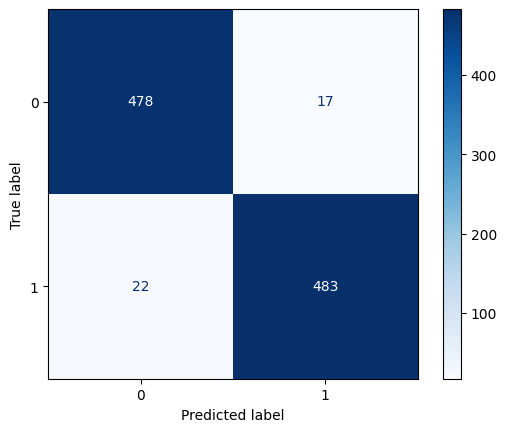

In [237]:
# Optional: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [238]:
# total token input cost: $0.0341835
(tokens['Input'].sum() * input_token_cost)

0.0341835

In [239]:
# total token output cost: $0.0015
(tokens['Output'].sum() * output_token_cost)

0.0015

In [240]:
# complete total token cost: $0.0356835
(tokens['Input'].sum() * input_token_cost) + (tokens['Output'].sum() * output_token_cost)

0.0356835

In [241]:
# 113367
tokens['Total'].sum()

113367